In [14]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.utils as vutils
from PIL import Image
import os
import matplotlib.pyplot as plt

from utils.generator import UNetGenerator

In [15]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    n_gpu = float(torch.cuda.device_count())
    device_name = torch.cuda.get_device_name(DEVICE)
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    device_name = "Apple Silicon"
    n_gpu = 0.0
else:
    DEVICE = torch.device("cpu")
    device_name = "CPU"
    n_gpu = 0.0
    
torch.manual_seed(0)
print(f"Training on {device_name} ({DEVICE})")

Training on NVIDIA GeForce RTX 4090 (cuda)


In [ ]:
IMAGE_SIZE = 256
NUM_CHANNELS = 3
ANOMALY_TYPES_FOR_TRAINING = ["crack", "glue_strip"]
DEFECT_MAP = {name: i for i, name in enumerate(ANOMALY_TYPES_FOR_TRAINING)}
NUM_CLASSES = len(DEFECT_MAP)
EMBED_SIZE = 16
NGF = 64 

In [ ]:
GENERATOR_CHECKPOINT_PATH = os.path.join(".", "checkpoints_cgan_tile", "cgan_generator_epoch_150.pth")
INPUT_IMAGE_PATH = os.path.join(".", "tile", "test", "good", "002.png")
INPUT_MASK_PATH = os.path.join(".", "sample_masks", "crack_000.png")
OUTPUT_IMAGE_PATH = os.path.join(".", "generated_defective_tile.png")
DESIRED_DEFECT_TYPE = "glue_strip"

In [18]:
print(f"Loading Generator from: {GENERATOR_CHECKPOINT_PATH}")
generator = UNetGenerator(num_channels=NUM_CHANNELS, num_classes=NUM_CLASSES, embed_size=EMBED_SIZE, ngf=NGF).to(DEVICE)

Loading Generator from: ./checkpoints_cgan_tile/cgan_generator_epoch_150.pth


In [19]:
generator.load_state_dict(torch.load(GENERATOR_CHECKPOINT_PATH, map_location=DEVICE))
generator.eval()

UNetGenerator(
  (label_embedding): Embedding(2, 16)
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(20, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): UNetDown(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down4): UNetDown(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): In

In [20]:
transform_image = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # To [-1, 1]
])
transform_mask = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor() # To [0.0, 1.0]
])

In [21]:
# Load good image
input_image_pil = Image.open(INPUT_IMAGE_PATH).convert('RGB')
input_image_tensor = transform_image(input_image_pil) # Shape: [C, H, W]

# Load custom mask (should be black background, white defect area)
mask_pil = Image.open(INPUT_MASK_PATH).convert('L') # Convert to grayscale
mask_tensor = transform_mask(mask_pil) # Shape: [1, H, W], Values: 0.0 or 1.0

# Get condition label
if DESIRED_DEFECT_TYPE not in DEFECT_MAP:
        raise ValueError(f"Desired defect type '{DESIRED_DEFECT_TYPE}' not in trained classes: {list(DEFECT_MAP.keys())}")
condition_label = DEFECT_MAP[DESIRED_DEFECT_TYPE]
condition_tensor = torch.tensor([condition_label]).long() # Shape: [1]

# Add batch dimension to all inputs
input_image_batch = input_image_tensor.unsqueeze(0).to(DEVICE) # [1, C, H, W]
mask_batch = mask_tensor.unsqueeze(0).to(DEVICE)                # [1, 1, H, W]
condition_batch = condition_tensor.to(DEVICE)                   # [1]

# Create the masked input for the generator
masked_input_batch = input_image_batch * (1.0 - mask_batch) + (-1.0 * mask_batch) # Set masked area to -1

In [22]:
with torch.no_grad(): # Disable gradient calculations for inference
    generated_image_batch = generator(masked_input_batch, mask_batch, condition_batch)

In [23]:
generated_image = generated_image_batch.squeeze(0).cpu()

In [24]:
generated_image_denorm = (generated_image * 0.5) + 0.5
generated_image_denorm = torch.clamp(generated_image_denorm, 0, 1)

In [25]:
vutils.save_image(generated_image_denorm, OUTPUT_IMAGE_PATH, normalize=False)
print(f"Saved generated image to {OUTPUT_IMAGE_PATH}")

Saved generated image to ./generated_defective_tile.png


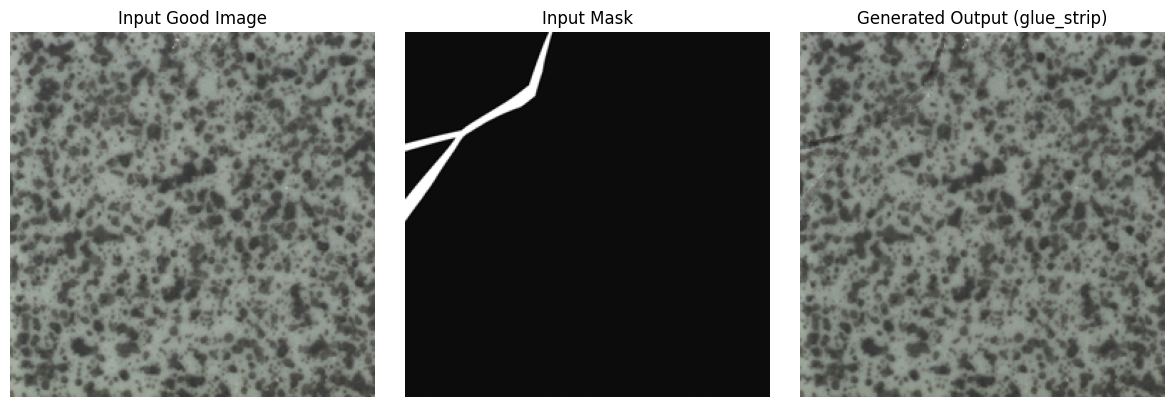

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_image_pil.resize((IMAGE_SIZE, IMAGE_SIZE))) # Show resized original
plt.title("Input Good Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_pil.resize((IMAGE_SIZE, IMAGE_SIZE)), cmap='gray') # Show resized mask
plt.title("Input Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(generated_image_denorm.permute(1, 2, 0).numpy()) # Permute C,H,W -> H,W,C
plt.title(f"Generated Output ({DESIRED_DEFECT_TYPE})")
plt.axis("off")

plt.tight_layout()
plt.show()